# Protein-ligand binding: Hidden Markov model analysis of Benzamidine-Trypsin binding

In this notebook we will use PyEMMA to analyze the binding kinetics of Benzamidine to Trypsin using 10 microseconds of trajectory data generated with ACEMD. The simulation setup can be found in [1]. The simulation setup and Benzamidine parameters were provided by Gianni De Fabritiis - thanks a lot, Gianni!

Our analysis will be based on Hidden Markov models as a coarse-grained Markov model variant - see [2] for details.

In [2]:
import pyemma
pyemma.__version__

'2.5.2'

In [3]:
import os
%pylab inline
matplotlib.rcParams.update({'font.size': 14})

Populating the interactive namespace from numpy and matplotlib


In [4]:
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mplt
from pyemma import config

This little helper function is used for saving figures. We can set the target directy and switch off saving by setting do_save=False here

In [5]:

import matplotlib.pyplot as plt

def save_figure_H(name, width=10, height=8, dpi=300, label_size=12, tick_size=12):
    """
    Saves the current figure with specified dimensions, DPI, and ensures
    x and y labels and ticks are of at least a specific font size.
    
    Parameters:
        name (str): The name of the file to save.
        width (float): The width of the figure in inches. Default is 10.
        height (float): The height of the figure in inches. Default is 8.
        dpi (int): The resolution in dots per inch. Default is 300.
        label_size (int): Font size for x and y labels. Default is 12.
        tick_size (int): Font size for x and y ticks. Default is 12.
    """
    do_save = True
    fig_dir = './'
    if do_save:
        # Update figure size
        plt.gcf().set_size_inches(width, height)
        
        # Update x and y label font sizes
        ax = plt.gca()
        ax.xaxis.label.set_size(label_size)
        ax.yaxis.label.set_size(label_size)
        
        # Update tick font sizes
        ax.tick_params(axis='x', labelsize=tick_size)
        ax.tick_params(axis='y', labelsize=tick_size)
        
        # Save the figure
        plt.savefig(fig_dir + name, bbox_inches='tight', dpi=dpi)



In [6]:
indir = '/home/farzin/Projects/Hydro-Binding/MSM/Hyd-WT-100H2/23-Bottleneck'
topfile =  indir+'/concatenated-H2-skipped-10-SampleFrame.pdb'
traj_list = ['/home/farzin/Projects/Hydro-Binding/MSM/Hyd-WT-100H2/concatenated-H2.xtc']


In [7]:
import pyemma

feat = pyemma.coordinates.featurizer(topfile)

# Define residue numbers
residues = [331, 379]

# Select non-hydrogen atoms explicitly by excluding known hydrogen names
atoms_331 = feat.select(f"resid {residues[0] - 1} and not name H and not name HA and not name HB and not name HG11 and not name HG12 and not name HG13 and not name HG21 and not name HG22 and not name HG23")
atoms_379 = feat.select(f"resid {residues[1] - 1} and not name H and not name HA and not name HG and not name HB1 and not name HB2 and not name HB3 and not name HD11 and not name HD12 and not name HD13 and not name HD21 and not name HD22 and not name HD23 and not name HD11 and not name HD11")

# Ensure valid atom selections
if len(atoms_331) == 0 or len(atoms_379) == 0:
    raise ValueError("Non-hydrogen atom selection for one of the residues is empty. Check the topology file.")

# Collect all pairwise distances between non-hydrogen atoms of residue 331 and residue 379
atom_pairs = [[atom1, atom2] for atom1 in atoms_331 for atom2 in atoms_379]

# Add all atom-pair distances as features
feat.add_distances(atom_pairs)

print(f"Feature setup completed with {len(atom_pairs)} pairwise distances between non-hydrogen atoms of residues 331 and 379.")


Feature setup completed with 56 pairwise distances between non-hydrogen atoms of residues 331 and 379.


In [8]:
feat.describe()[:1000]

['DIST: VAL 333 N 4966 - LEU 381 N 5720',
 'DIST: VAL 333 N 4966 - LEU 381 CA 5722',
 'DIST: VAL 333 N 4966 - LEU 381 CB 5724',
 'DIST: VAL 333 N 4966 - LEU 381 CG 5727',
 'DIST: VAL 333 N 4966 - LEU 381 CD1 5729',
 'DIST: VAL 333 N 4966 - LEU 381 CD2 5733',
 'DIST: VAL 333 N 4966 - LEU 381 C 5737',
 'DIST: VAL 333 N 4966 - LEU 381 O 5738',
 'DIST: VAL 333 CA 4968 - LEU 381 N 5720',
 'DIST: VAL 333 CA 4968 - LEU 381 CA 5722',
 'DIST: VAL 333 CA 4968 - LEU 381 CB 5724',
 'DIST: VAL 333 CA 4968 - LEU 381 CG 5727',
 'DIST: VAL 333 CA 4968 - LEU 381 CD1 5729',
 'DIST: VAL 333 CA 4968 - LEU 381 CD2 5733',
 'DIST: VAL 333 CA 4968 - LEU 381 C 5737',
 'DIST: VAL 333 CA 4968 - LEU 381 O 5738',
 'DIST: VAL 333 CB 4970 - LEU 381 N 5720',
 'DIST: VAL 333 CB 4970 - LEU 381 CA 5722',
 'DIST: VAL 333 CB 4970 - LEU 381 CB 5724',
 'DIST: VAL 333 CB 4970 - LEU 381 CG 5727',
 'DIST: VAL 333 CB 4970 - LEU 381 CD1 5729',
 'DIST: VAL 333 CB 4970 - LEU 381 CD2 5733',
 'DIST: VAL 333 CB 4970 - LEU 381 C 5737'

In [9]:
inp = coor.source(traj_list, feat)
X = inp.get_output(chunk=1000)
print('Number of trajectories = ', len(X))
print('Trajectory length = ', X[0].shape[0])
print('Total data = ', len(X) * X[0].shape[0], 'frames')
print('Number of dimensions = ', X[0].shape[1])

# Check the distances for the first few frames
print("Distances (first few frames):", X[0][:10])


100%|██████████| 1876/1876 [21:07<00:00,  1.48it/s]                                 

Number of trajectories =  1
Trajectory length =  1875001
Total data =  1875001 frames
Number of dimensions =  56
Distances (first few frames): [[ 1.34637058  1.31939888  1.18363428  1.05884242  0.93415487  1.04296911
   1.44183612  1.48558736  1.22536075  1.20259488  1.06483114  0.9412834
   0.81142616  0.93957525  1.32316542  1.37302196  1.12048817  1.08393598
   0.94291991  0.82731688  0.69540435  0.82327294  1.19986725  1.24201846
   0.97036928  0.93915594  0.79867941  0.68065113  0.54696983  0.6877653
   1.05659735  1.10525322  1.12806857  1.08155715  0.94694501  0.83123654
   0.71411639  0.80130482  1.20015919  1.23072124  1.26671088  1.24722075
   1.10471106  0.98974431  0.85017049  1.00952506  1.35974479  1.41537857
   1.22785914  1.22054303  1.08164418  0.96481144  0.82734466  0.99579632
   1.33366013  1.39809072]
 [ 1.2742219   1.25484908  1.13146102  0.99630272  0.88956428  0.95675051
   1.37493765  1.40189517  1.16471732  1.14874947  1.02025545  0.8851611
   0.77162921  0.86

In [10]:
tica_lag = 100  # tica lagtime, 5,000 ps (XTC every 10 ps)
#tica_obj = coor.tica(X, lag=tica_lag)
tica_obj = coor.tica(X, lag=tica_lag)

Y = tica_obj.get_output()[0]
print('Projected data shape = ', Y.shape)

Projected data shape =  (1875001, 24)


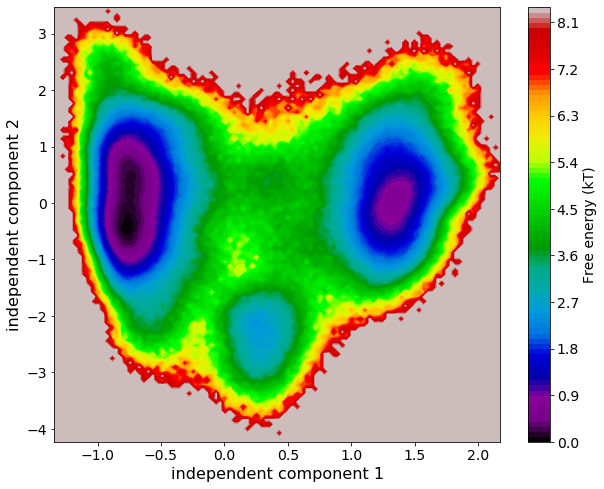

In [13]:
mplt.plot_free_energy(np.vstack(Y)[:, 0], np.vstack(Y)[:, 1])
xlabel('independent component 1'); ylabel('independent component 2'); figsize=(16, 12)
save_figure_H('free_energy-1000ps-TICA-Bottleneck.png', label_size=16, tick_size=14)

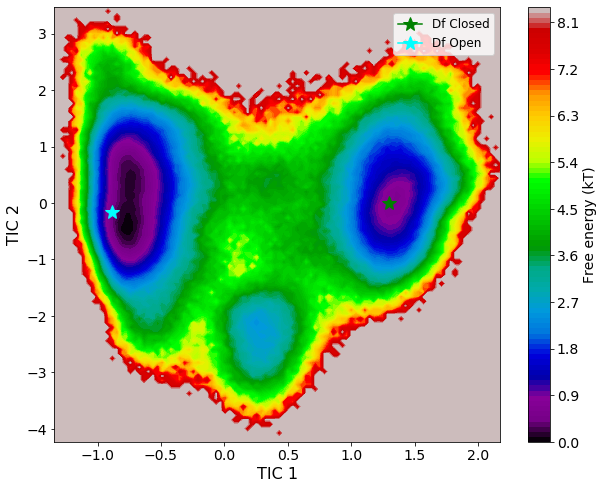

In [ ]:
import mdtraj as md
import matplotlib.pyplot as plt
import pyemma.plots as mplt


# Frame indices-cluster-center
frame_index_Df_closed = 1000717
frame_index_Df_Open = 768147


traj_file = traj_list[0]
topology = topfile

frame_closed = md.load(traj_file, top=topology, frame=frame_index_Df_closed)
frame_open = md.load(traj_file, top=topology, frame=frame_index_Df_Open)

# Transform to feature space
features_closed = feat.transform(frame_closed)
features_open = feat.transform(frame_open)

# Project to TICA space
tica_closed = tica_obj.transform(features_closed)
tica_open = tica_obj.transform(features_open)

plt.figure(figsize=(12, 10))
mplt.plot_free_energy(np.vstack(Y)[:, 0], np.vstack(Y)[:, 1])
plt.plot(tica_closed[0, 0], tica_closed[0, 1], marker='*', color='green', markersize=15, label='Df Closed')
plt.plot(tica_open[0, 0], tica_open[0, 1], marker='*', color='cyan', markersize=15, label='Df Open')
plt.xlabel('TIC 1', fontsize=14)
plt.ylabel('TIC 2', fontsize=14)
plt.legend(fontsize=12)
save_figure_H('FEL_with_Df_states-centers.png', label_size=16, tick_size=14)
plt.show()


